<a href="https://colab.research.google.com/github/Azamat0315277/pytorch_model_deployment/blob/main/Food_Vision_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting setup 

In [1]:
# import scripts
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo()
try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory
try:
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going_modular scripts
  print(f"[INFO] Couldn't find going_modular or helper_functions scripts")
  #!git clone https://github.com/mrdbourke/pytorch-deep-learning
  !git clone https://github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision

  !mv pytorch_paper_replicating_for_computer_vision/going_modular .
  !mv pytorch_paper_replicating_for_computer_vision/helper_functions.py . 
  !rm -rf pytorch_paper_replicating_for_computer_vision
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts
Cloning into 'pytorch_paper_replicating_for_computer_vision'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 44 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), 24.58 MiB | 4.34 MiB/s, done.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Getting data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directory paths
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

# Food Vision model deployment deployment

## Creating an EffNetB2 feature extractor

In [ ]:
# Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
# Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()
# Setup pratrained model
effnet_b2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# freeze the base layers
for param in effnet_b2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [ ]:
# check out model head
effnet_b2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# Update (change) the classifer head
effnet_b2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

## Creating a function to make an EffNetB2 feature extractor

In [2]:
def create_effnetb2_model(num_classes: int=3,
                          seed: int=42):
  """
  Creates an EffNetB2 feature extractor model and transforms
  """

  # Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze all layers in base model
  for param in model.parameters():
    requires_grad=False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408,
                out_features=num_classes)
  )
  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)


In [ ]:
# Get summary of model

from torchinfo import summary 
# Print EffNetB2 model summary

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## Creating DataLoaders for EffNetB2

In [ ]:
# Setup Dataloader
from going_modular import data_setup 

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

## Training EffNetB2 feature extractor

In [ ]:
from going_modular import engine 

# Setup optimizer

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001)
# Setup loss
loss_fn = torch.nn.CrossEntropyLoss()

# set seeds

set_seeds()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=20,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4683 | train_acc: 0.8250 | test_loss: 0.1230 | test_acc: 0.9722
Epoch: 2 | train_loss: 0.2696 | train_acc: 0.9396 | test_loss: 0.1559 | test_acc: 0.9437
Epoch: 3 | train_loss: 0.2660 | train_acc: 0.9271 | test_loss: 0.1126 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.1949 | train_acc: 0.9229 | test_loss: 0.1194 | test_acc: 0.9500
Epoch: 5 | train_loss: 0.2322 | train_acc: 0.9354 | test_loss: 0.0629 | test_acc: 0.9875
Epoch: 6 | train_loss: 0.2456 | train_acc: 0.9292 | test_loss: 0.1314 | test_acc: 0.9784
Epoch: 7 | train_loss: 0.6145 | train_acc: 0.8729 | test_loss: 0.4380 | test_acc: 0.8682
Epoch: 8 | train_loss: 0.4341 | train_acc: 0.8604 | test_loss: 0.1944 | test_acc: 0.9386
Epoch: 9 | train_loss: 0.1903 | train_acc: 0.9250 | test_loss: 0.1027 | test_acc: 0.9597
Epoch: 10 | train_loss: 0.1467 | train_acc: 0.9083 | test_loss: 0.0759 | test_acc: 0.9750
Epoch: 11 | train_loss: 0.1606 | train_acc: 0.9479 | test_loss: 0.1561 | test_acc: 0.9375
Epoch: 12 | train_l

## Inspecting EffNetB2 loss curves

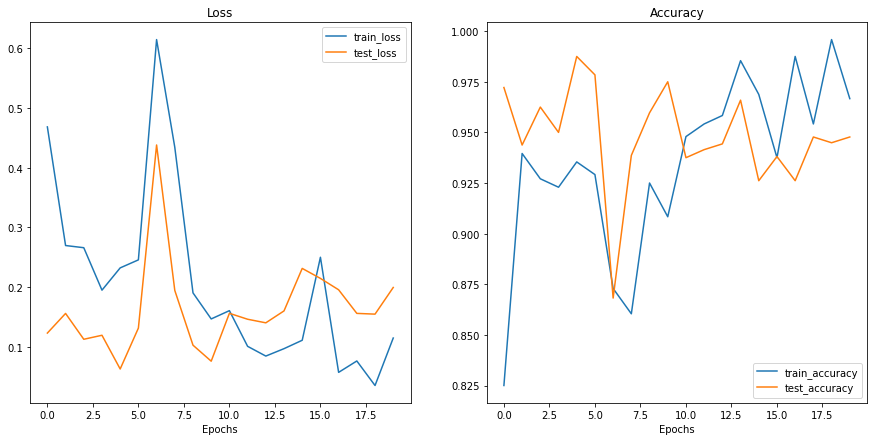

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## Saving EffNetB2 feature extractor

In [ ]:
from going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


## Checking the size of EffNetB2 

In [ ]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size //(1024*1024) # division converts bytes to megabytes 

print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")


Pretrained EffNetB2 feature extractor model size: 29 MB


## Collecting EffNetB2 stats

In [ ]:
# Count nuumber of parameters in EffNetB2 
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 stats

effnetb2_stats = {"test_loss": effnetb2_results['test_loss'][-1],
                  "test_acc": effnetb2_results['test_acc'][-1],
                  'number_of_parameters': effnetb2_total_params,
                  "model_size (MB)":pretrained_effnetb2_model_size
                  }
effnetb2_stats
      

{'test_loss': 0.1993967060931027,
 'test_acc': 0.9477272727272726,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

# Creating A ViT feature extractor

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes: int=3,
                     seed: int=42):
  """ 
  Creates a ViT-B/16 feature extractor model and transforms
  """
  # Creates ViT_B_16 pretrained weights, transfroms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all layers in model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(42)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                        out_features=num_classes))
  
  return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
from torchinfo import summary

summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Create  Dataloaders 

In [ ]:
# Setup ViT Dataloaders

from going_modular import data_setup 

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

## Training ViT model

In [ ]:
from going_modular import engine 

optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=20,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847
Epoch: 11 | train_loss: 0.0593 | train_acc: 0.9854 | test_loss: 0.0600 | test_acc: 0.9938
Epoch: 12 | train_l

## Inspecting ViT loss curves

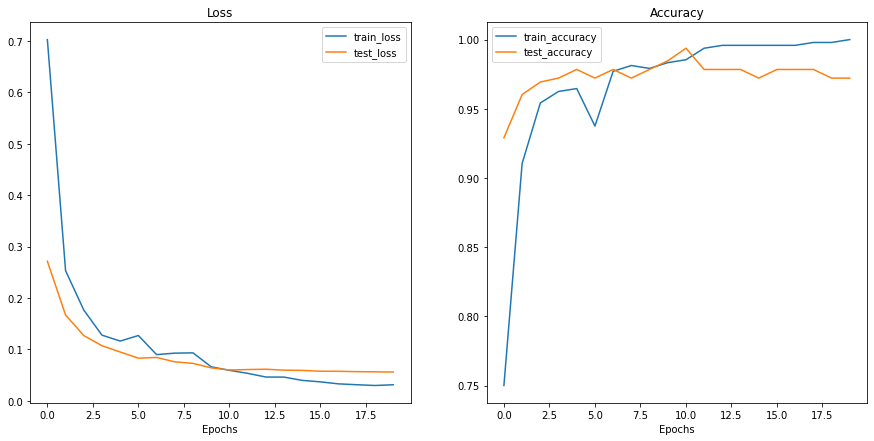

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

## Saving ViT feature extractor

In [ ]:
# Save the model
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


## Checking the size of ViT 

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")



Pretrained ViT feature extractor model size: 327 MB


## Collecting ViT stats

In [ ]:
# Count number of parameters in ViT

vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
vit_stats = {'test_loss': vit_results['test_loss'][-1],
             'test_acc': vit_results['test_acc'][-1],
             'number_of_parameters': vit_total_params,
             'model_size (MB)': pretrained_vit_model_size
             }
vit_stats


{'test_loss': 0.05601070134434849,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

# Making predictions with trained models and timing them

In [ ]:
from pathlib import Path 

# Get all test data paths

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/670345.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg')]

## Creating a function to make predictions across the test dataset

In [ ]:
import pathlib
import torch

from PIL import Image 
from timeit import default_timer as timer 
from tqdm.auto import tqdm 
from typing import List, Dict

# Create a  function to return a list of dictionaries with
# sample, true_label, pred_label, predict_proba and prediction time

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> List[Dict]:
  
  # Create an empty list
  pred_list = []

  # Loop through target paths
  for path in tqdm(paths):
    
    # Create empty dictionary to store prediction information for each sample
    pred_dict = {}

    # Get the sample path and ground truth class name
    pred_dict['image_path'] = path
    class_name = path.parent.stem 
    pred_dict['class_name'] = class_name

    # Start the prediction timer
    start_time = timer()

    # Open image path 
    img = Image.open(path)

    # Transform the image, add batch dimension an put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # Prepare model for inference by sending it to target device and turning on eval() model
    model.to(device)
    model.eval()

    # Get prediction probabilty, pred_label and pred_class
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the directory are on CPU
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict['pred_class'] = pred_class 

      # end timer and calculate time per pred
      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time-start_time, 4)

    # Does the pred match the true label
    pred_dict['correct'] = class_name == pred_class

    # Add the dictionary to list
    pred_list.append(pred_dict)

  return pred_list

## Making and timing predictions with EffNetB2

In [ ]:
# Make predictions across test dataset
effnetb2_test_pred_dicts  = pred_and_store(paths=test_data_paths,
                                           model=effnetb2,
                                           transform=effnetb2_transforms,
                                           class_names=class_names,
                                           device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 2 prediction 
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
  'class_name': 'steak',
  'pred_prob': 1.0,
  'pred_class': 'steak',
  'time_for_pred': 0.3239,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
  'class_name': 'steak',
  'pred_prob': 1.0,
  'pred_class': 'steak',
  'time_for_pred': 0.1029,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,1.0000,steak,0.3239,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,1.0000,steak,0.1029,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,1.0000,steak,0.1051,True
3,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,1.0000,steak,0.1074,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,1.0000,steak,0.1115,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9850,sushi,0.0928,True
146,data/pizza_steak_sushi_20_percent/test/sushi/8...,sushi,0.9993,sushi,0.0959,True
147,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9963,sushi,0.1095,True
148,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9986,sushi,0.1045,True


In [ ]:
# Check the number of correct preds
effnetb2_test_pred_df.correct.value_counts()

True     143
False      7
Name: correct, dtype: int64

In [ ]:
# Find average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1114 seconds


In [ ]:
# Add EffNertB2 average prediction time to stats dictionary
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.1993967060931027,
 'test_acc': 0.9477272727272726,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1114}

## Making an timing predicts with ViT

In [ ]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first 2 predictions
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9993,
  'pred_class': 'steak',
  'time_for_pred': 0.7134,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.5472,
  'pred_class': 'steak',
  'time_for_pred': 0.8935,
  'correct': True}]

In [ ]:
# Turn vit_test_pred_dicts into DataFrame

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9993,steak,0.7134,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.5472,steak,0.8935,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9968,steak,0.8901,True
3,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.9998,steak,0.8843,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9986,steak,0.8615,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9304,sushi,0.5169,True
146,data/pizza_steak_sushi_20_percent/test/sushi/8...,sushi,0.9865,sushi,0.5193,True
147,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9941,sushi,0.5150,True
148,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9912,sushi,0.5562,True


In [ ]:
# Check corrects
vit_test_pred_df.correct.value_counts()

True     146
False      4
Name: correct, dtype: int64

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.6118 seconds


In [ ]:
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05601070134434849,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.6118}

# Comparing model results, predicton times ans size


In [ ]:
# Turn stat dicts into DataFrame
df = pd.DataFrame([effnetb2_stats,vit_stats])
df['model'] = ['EffNetB2', 'ViT']

# Convert accuracy to percentage
df['test_acc'] = round(df['test_acc'] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.199397,94.77,7705221,29,0.1114,EffNetB2
1,0.056011,97.22,85800963,327,0.6118,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characterisrics
pd.DataFrame(data=(df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2']),
             columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.280901,1.025852,11.135432,11.275862,5.491921


## Visualizing the speed vs. performance tradeoff

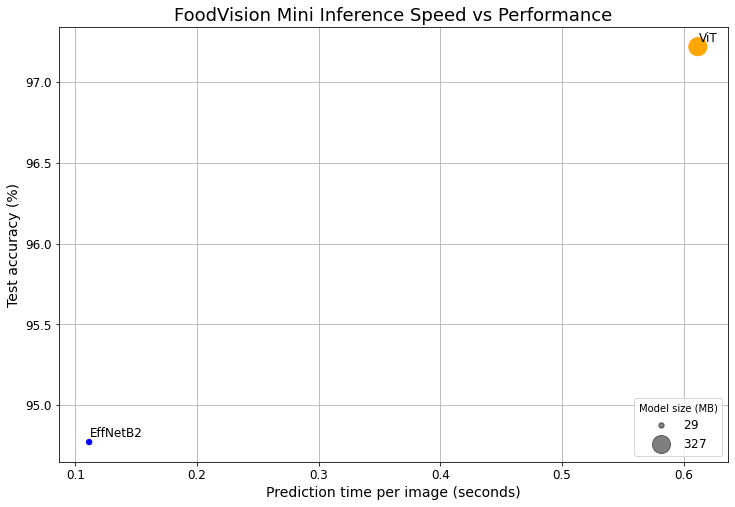

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Show the figure
plt.show()

# Bringing FoodVision Mini to life by creating a Gradio demo

In [ ]:
# Import/install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f'Gradio version: {gr.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 15.7 MB/s eta 0:00:

## Creating a function to map inputs and outputs

In [ ]:
# Put EffNetB2 on CPU
effnet_b2.to('cpu')

# Check the device
next(iter(effnet_b2.parameters())).device

device(type='cpu')

## Create `predict()` function 

In [ ]:
from typing import Tuple, Dict

def predict(img) ->Tuple[Dict, float]:
  """
  Transforms nad performs a prediction on img and returns prediction and time taken
  """
  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and 
    # turn the prediction logits into predict proba
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and predict proba dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dict and pred time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/724290.jpg

Prediction label and probability dictionary: 
{'pizza': 0.9938246011734009, 'steak': 0.0009674896136857569, 'sushi': 0.005207938142120838}
Prediction time: 0.10565 seconds


## Creating a list of examples images

In [ ]:
# Create a list of examples inputs to Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/3177743.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/86782.jpg']]

## Building a Gradio interface

In [ ]:
import gradio as gr

# Create title, description and article strings
title = 'FoodVision Mini 🍕🥩🍣'
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type='pil'), # type of inputs
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'), # type of outputs
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)
# Launch the demo

demo.launch(debug=False, 
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b269bccbb68174e41b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


# Turning FoodVision Mini Gradio Demo into a deployable app

## Creating a `demos` folder to store FoodVision Mini app files

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path('demos/foodvision_mini/')

# Remove files that might already exists there and create new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  # If the file doesn't exists, create it anyway
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
  
!ls demos/foodvision_mini/

## Creating a folder of examples images to use with FoodVision Mini demo

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
import os
# get examples filepaths in a list of lists
example_list = [['example/'+ example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['example/2582289.jpg'], ['example/3622237.jpg'], ['example/592799.jpg']]

In [ ]:
## Moving trained EffnetB2 model to FoodVission Mini demo directory
import shutil

# Create a source path for target model
effnetb2_foodvision_mini_model_path = 'models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'

# Create a destination path for target model

effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split('/')[1]

# Try to move the file

try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)
  print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, paerhaps its already been moved")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


## Turning EffNetB2 model into a Python script(model.py)

In [ ]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int=3,seed: int=42):
  """
  Creates an  EfficientNetB2 feature extractor model and transforms
  """
  # Create EffNetB2 pretrained weights, transfroms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transform()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze all layers in base model
  for param in model.parameters():
    param.requires_grad=False

  # Change classifier head with random seed for reproducibility 
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms


Writing demos/foodvision_mini/model.py


## Turning FoodVision Mini Gradio app into a Python script (app.py)

In [ ]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch 

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### Model and transforms preparation ###

effnet_b2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

# Load a saved weights
effnet_b2.load_state_dict(
  torch.load(
    f='09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'',
    map_location=torch.device('cpu')
  )
)

### Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
  """
  Transforms and performs a prediction on img and returns
  prediction and time taken
  """

  # Start timer
  start_timer = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  effnet_b2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the 
    # prediction logits into predict_proba
    pred_probs = torch.softmax(effnet_b2(img), dim=1)

  # Create  a prediction label and predict_proba dictionary for each predict class
  pred_labels_and_probs = {class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_timer, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

### Gradio app ###

title = 'FoodVision Big 👁️🍛'
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizz, steak, or sushi."
article = "Created at https://github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision"

# Create examples list from 'examples/' directory

example_list = [['examples/'+ example] for example in os.listdir('examples')]

# Create the Gradio
demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                    gr.Number(label="Prediction time (s)")],
                    # Creates examples list from 'examples/' directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch demo

demo.launch()

Writing demos/foodvision_mini/app.py


## Creating a requirements file for FoddVision Mini (`requirements.txt`)

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


# Deploying FoodVision Mini app to HuggingFace Spaces

In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [ ]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [ ]:
# Download the zipped FoodVision Mini app
# try:
#   from google.colab import files 
#   files.download('demos/foodvision_mini.zip')
# except:
#   print("Not running in Google Colab, can't use google. colab.files.download(), please manually download")

## Uploading to Hugging Face

In [ ]:
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/Azamat0315277/foodvision_mini/+", width=900, height=750)

# Creating FoodVision Big

## Creating a model and transforms for FoodVision Big

In [5]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [6]:
#  Create Food101 training data transforms (only perform data augmentation on train set)
food101_train_transforms = torchvision.transforms.Compose([
      torchvision.transforms.TrivialAugmentWide(),
      effnetb2_transforms
])



## Getting data for FoodVision Big

In [7]:
from torchvision import datasets

# Setup data directory

from pathlib import Path
data_dir = Path('data')

# Get training data
train_data = datasets.Food101(root=data_dir,
                               split='train',
                               transform=food101_train_transforms,
                               download=True)

test_data = datasets.Food101(root=data_dir,
                             split='test',
                             transform=effnetb2_transforms,
                             download=True)

  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/food-101.tar.gz to data


In [8]:
# Get Food101 class names
food101_class_names = train_data.classes

food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Creating a subset of the Food dataset for faster experimenting

## Turning FoodVision datasets into `Dataloader`s

In [ ]:
len(train_data), len(test_data)

(75750, 25250)

In [ ]:
import os
import torch 

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4

# Create Dataloaders
train_dataloader_food101 = torch.utils.data.DataLoader(train_data,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       num_workers=NUM_WORKERS)

test_dataloader_food101 = torch.utils.data.DataLoader(test_data,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False,
                                                      num_workers=NUM_WORKERS)

## Training FoodVision Big

In [ ]:
from going_modular import engine 

# Setup optimizer 
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=0.001)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101,
                                        test_dataloader= test_dataloader_food101,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3898 | train_acc: 0.5389 | test_loss: 1.6083 | test_acc: 0.7668
Epoch: 2 | train_loss: 1.9194 | train_acc: 0.6716 | test_loss: 1.4961 | test_acc: 0.7953
Epoch: 3 | train_loss: 1.7759 | train_acc: 0.7124 | test_loss: 1.4469 | test_acc: 0.8108
Epoch: 4 | train_loss: 1.6778 | train_acc: 0.7443 | test_loss: 1.3933 | test_acc: 0.8212
Epoch: 5 | train_loss: 1.6036 | train_acc: 0.7636 | test_loss: 1.3661 | test_acc: 0.8308


## Inspecting loss curves of FoodVision Big

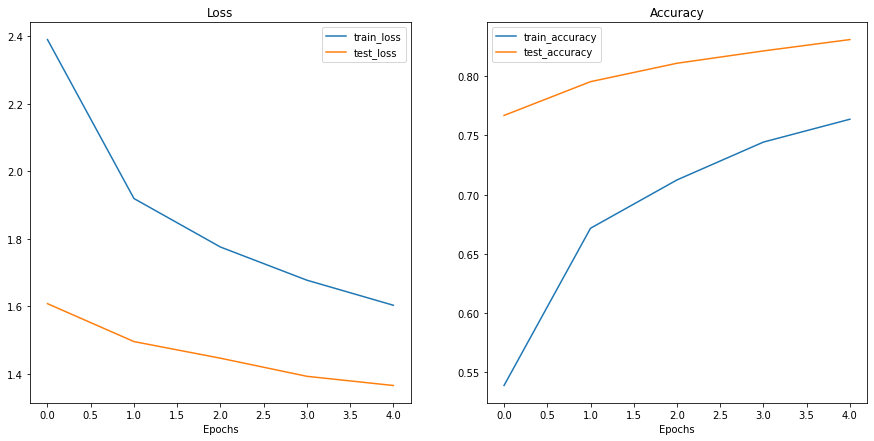

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

## Saving and loading FoodVision Big

In [ ]:
from going_modular import utils

# Create a model path
effnetb2_food101_model_path = "/content/drive/MyDrive/Models/pretrained_effnetb2_feature_extractor_food101_all.pth" 

# Save model
utils.save_model(model=effnetb2_food101,
                 target_dir='models',
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: /content/drive/MyDrive/Models/pretrained_effnetb2_feature_extractor_food101_all.pth


In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load model
loaded_effnetb2_food101.load_state_dict(torch.load('/content/drive/MyDrive/Models/pretrained_effnetb2_feature_extractor_food101_all.pth'))

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

<All keys matched successfully>

## Checking FoodVision Bid model size

In [ ]:
from pathlib import Path

pretrained_effnetb2_food101_model_size = Path("/content/drive/MyDrive/Models", 'pretrained_effnetb2_feature_extractor_food101_all.pth').stat().st_size // (1024*1024)
print(f"Prefetched EffnetB2 Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Prefetched EffnetB2 Food101 model size: 30 MB


# Turning FoodVision Big model into a deployable app

Create directory with structure like below:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_all.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```
* `09_pretrained_effnetb2_feature_extractor_food101_all.pth` is trained Pytorch model file. 
* `app.py` contains FoodVision Big Gradio app. 
* `class_names.txt` contains all of the class names of FoodVision Big. 
* `examples/` contains example images to use with Gradio app. 
* `model.py` contains the model definition as well as any transforms assosiated wwith the model. 
* `requirements.txt` 


In [ ]:
from pathlib import Path 

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make examples directory
(foodvision_big_demo_path / 'examples').mkdir(parents=True, exist_ok=True)

## Downloading an example image and moving it to the `example` directory

In [ ]:
!wget https://raw.github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/marina-grynykha-FBgCgJhPO2I-unsplash.jpg
!wget https://raw.github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/shourav-sheikh-a66sGfOnnqQ-unsplash.jpg
!wget https://raw.github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/tim-toomey-pe9dvM1rQkM-unsplash.jpg


--2023-03-12 11:16:22--  https://raw.github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/marina-grynykha-FBgCgJhPO2I-unsplash.jpg
Resolving raw.github.com (raw.github.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/marina-grynykha-FBgCgJhPO2I-unsplash.jpg [following]
--2023-03-12 11:16:22--  https://raw.githubusercontent.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/marina-grynykha-FBgCgJhPO2I-unsplash.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
# Get example images from github
!wget https://raw.github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/marina-grynykha-FBgCgJhPO2I-unsplash.jpg
!wget https://raw.github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/shourav-sheikh-a66sGfOnnqQ-unsplash.jpg
!wget https://raw.github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/tim-toomey-pe9dvM1rQkM-unsplash.jpg
# Move examples into example directory
!mv /content/marina-grynykha-FBgCgJhPO2I-unsplash.jpg  /content/demos/foodvision_big/examples/marina-grynykha-FBgCgJhPO2I-unsplash.jpg
!mv /content/shourav-sheikh-a66sGfOnnqQ-unsplash.jpg /content/demos/foodvision_big/examples/shourav-sheikh-a66sGfOnnqQ-unsplash.jpg
!mv /content/tim-toomey-pe9dvM1rQkM-unsplash.jpg  /content/demos/foodvision_big/examples/tim-toomey-pe9dvM1rQkM-unsplash.jpg

# Move trained model into Food101 Big demo folder
!mv /content/drive/MyDrive/Models/pretrained_effnetb2_feature_extractor_food101_all.pth /content/demos/foodvision_big

--2023-03-12 11:22:21--  https://raw.github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/marina-grynykha-FBgCgJhPO2I-unsplash.jpg
Resolving raw.github.com (raw.github.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/marina-grynykha-FBgCgJhPO2I-unsplash.jpg [following]
--2023-03-12 11:22:21--  https://raw.githubusercontent.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/main/example/marina-grynykha-FBgCgJhPO2I-unsplash.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

## Saving Food101 class names to file

In [ ]:
# Create path
foodvision_big_class_names_path = foodvision_big_demo_path / 'class_names.txt'

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, 'w') as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# Check class names
with open(foodvision_big_class_names_path, 'r') as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

## Create `model.py`




In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int=3,seed: int=42):
  """
  Creates an  EfficientNetB2 feature extractor model and transforms
  """
  # Create EffNetB2 pretrained weights, transfroms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transform()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze all layers in base model
  for param in model.parameters():
    param.requires_grad=False

  # Change classifier head with random seed for reproducibility 
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_big/model.py


## Create `app.py`

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]
    
### 2. Model and transforms preparation ###    

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_food101_all.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes]"
article = "Created at https://github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


## Create a requirements

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_big/requirements.txt


## Downloading FoodVision Big app files

In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/tim-toomey-pe9dvM1rQkM-unsplash.jpg (deflated 1%)
  adding: examples/marina-grynykha-FBgCgJhPO2I-unsplash.jpg (deflated 3%)
  adding: examples/shourav-sheikh-a66sGfOnnqQ-unsplash.jpg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: pretrained_effnetb2_feature_extractor_food101_all.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>